# This is a practice notebook for debugging issues with the astrotog package. 

In [1]:
import numpy as np
import sncosmo
from math import inf
from astropy.cosmology import Planck15 as cosmo
from astrotog import transient_obs_dist as tod
import matplotlib.pyplot as plt
from copy import deepcopy

## Define the general file paths and parameters

### Survey and SED file paths

In [2]:
surveydb_path = '/Users/cnsetzer/Documents/LSST/surveydbs/minion_1016_sqlite.db'
fields = ['fieldID', 'fieldRA', 'fieldDec', 'filter', 'expMJD', 'fiveSigmaDepth']
db_flag = 'wfd'
sedsdb_path = "../sedb/rosswog/NSNS/winds"
gen_flag = 'cycle'

In [3]:
param_priors = {'zmin': 0.0, 'zmax': 0.1, 'cosmology': cosmo,
                'kappa_min': 1, 'kappa_max': 10, 'm_ej_min': 0.01,
                'm_ej_max': 0.2, 'v_ej_min': 0.01, 'v_ej_max': 0.5}
instrument_params = {'FOV_rad': np.deg2rad(1.75), 'Mag_Sys': 'ab'}
Cuts = {'SNR': {'upper': inf, 'lower': 5}}
z0 = 0.00000225975 #redshift of 10pc for purpose of placing the SEDs
z1 = 1.0

## Get the SEDs from the provided data files and create data construct

In [4]:
sed_db = tod.Get_SEDdb(sedsdb_path)

### Get a small subset (one sed) to work with and debug with

In [5]:
test_sed = {}
test_key = 'SED_wind16'
test_model = deepcopy(sed_db[test_key]['model'])
test_sed[test_key] = deepcopy(sed_db[test_key])

In [6]:
lsst_bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']

### Plot some of the lightcurves of this SED to get an idea of what's going on

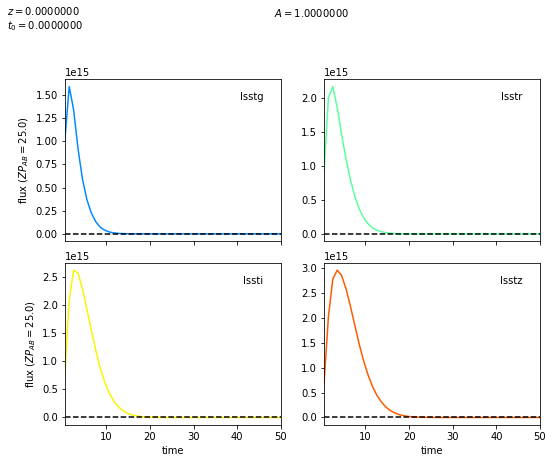

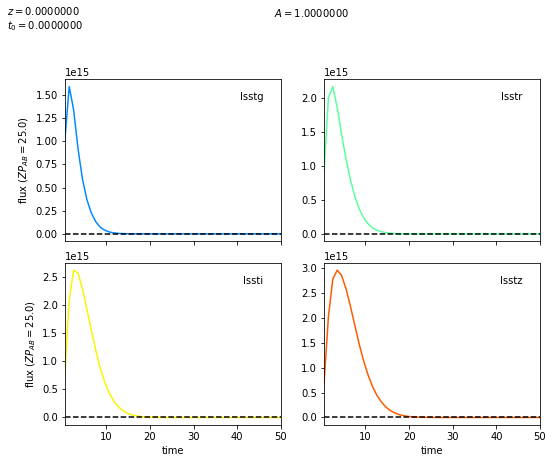

In [7]:
sncosmo.plot_lc(model = test_sed[test_key]['model'], bands = lsst_bands)

### Setup the wavelengths and time for SED comparison before and after redshifting

In [8]:
wavelengths = np.linspace(test_model.minwave()+1000,test_model.maxwave()-1000,100)
time_red_compare = 3.0

### Output a flux to compare with .dat file to make sure data is read in correctly

In [9]:
pre_z_flux = deepcopy(test_model.flux(time_red_compare,wavelengths))

In [10]:
R_Abs_Mag = deepcopy(test_model.bandmag('lsstr','ab',time_red_compare))

## Begin to investigate how setting the redshift affects the model and flux/amplitudes

In [11]:
test_model_only_z = deepcopy(test_sed[test_key]['model'])
test_model_only_z.set(z = z1)
test_sed_z_and_amp = deepcopy(tod.Set_SED_Redshift(test_sed, [z1],cosmo))

In [12]:
post_z_flux_only_z = deepcopy(test_model_only_z.flux(time_red_compare, wavelengths))
post_z_flux_both = deepcopy(test_sed_z_and_amp[test_key]['model'].flux(time_red_compare,wavelengths))

### Plot new lightcurves and plot the fluxes from the different redshifting methods

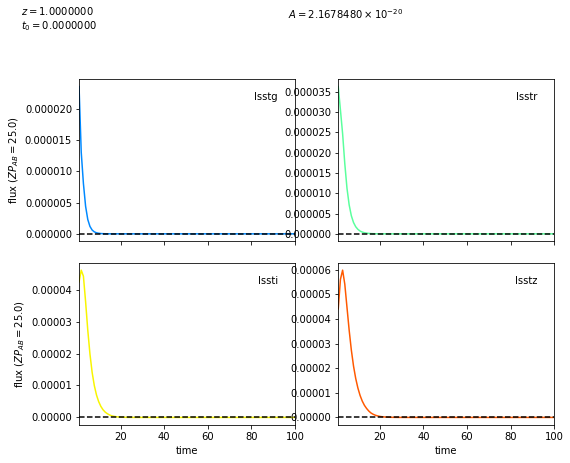

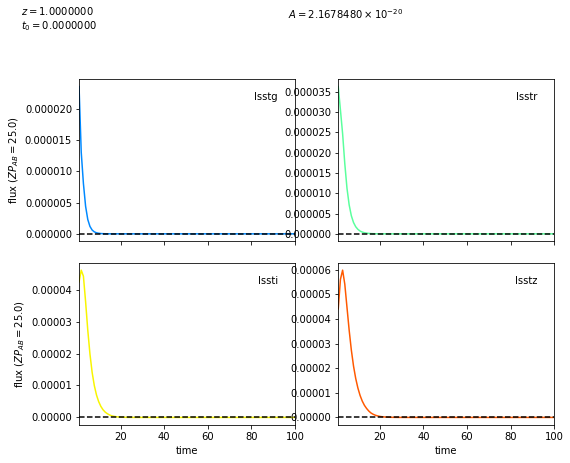

In [13]:
sncosmo.plot_lc(model = test_sed[test_key]['model'], bands = lsst_bands)

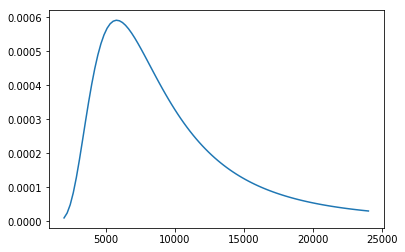

In [14]:
plt.plot(wavelengths,pre_z_flux)

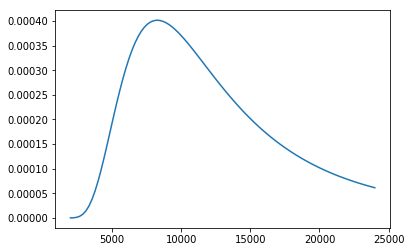

In [15]:
plt.plot(wavelengths,post_z_flux_only_z)

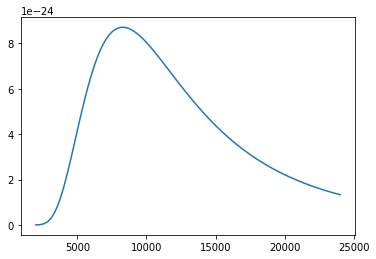

In [16]:
plt.plot(wavelengths,post_z_flux_both)

In [17]:
test_model.bandmag('lsstr','ab',time_red_compare)

-13.279670967614825

## Do the apparent magnitude calculation manually to compare the output from the code

In [25]:
lum_dist_Mpc = cosmo.luminosity_distance(z1).value
lum_dist_pc = lum_dist_Mpc * 1e6

In [26]:
R_app_mag_straightforward = R_Abs_Mag + 5*np.log10(lum_dist_pc) - 5
R_app_mag_code_both = test_sed_z_and_amp[test_key]['model'].bandmag('lsstr','ab',time_red_compare)
R_app_mag_code_z = test_model_only_z.bandmag('lsstr','ab',time_red_compare)
R_app_mag_code_z_plus_shift = R_app_mag_code_z + 5*np.log10(lum_dist_pc) - 5
print(R_app_mag_straightforward,R_app_mag_code_z, R_app_mag_code_both, R_app_mag_code_z_plus_shift)

30.8802569392 -12.6406014374 36.5193264694 31.5193264694


### Something odd seems to be happening with how sncosmo sets the magnitude

In [27]:
cosmo.distmod(z1).value + R_app_mag_code_z

31.519326469376736

### Need to look into how the amplitude setting is not matching the computed z-dist


### Do the comparison but now through fluxes